## **PROYEK KEDUA BELAJAR PENGEMBANGAN MACHINE LEARNING**
## **Membuat Model Machine Learning dengan Data Time Series**
#Nama : Addina Dwi Nugroho
#Email : addin27nugroho@gmail.com

In [19]:
#sambung google colab ke google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#import library yang dibutuhkan
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [21]:
#baca dataset
df = pd.read_csv("/content/drive/My Drive/dataset/Weather in Szeged 2006-2016.csv")

In [22]:
#preprocessing data
df = df[["Formatted Date","Temperature (C)"]]

In [23]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

In [24]:
df = df.set_index('Formatted Date')

In [25]:
df = df.resample('D').mean()

In [26]:
df = df.reset_index()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Formatted Date   4019 non-null   datetime64[ns, UTC]
 1   Temperature (C)  4019 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 62.9 KB


In [28]:
df.head()

,Formatted Date,Temperature (C)
0,2005-12-31 00:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,4.075000
2,2006-01-02 00:00:00+00:00,5.263194
3,2006-01-03 00:00:00+00:00,2.340509
4,2006-01-04 00:00:00+00:00,2.251852


In [29]:
df.isnull().sum()

Formatted Date     0
Temperature (C)    0
dtype: int64

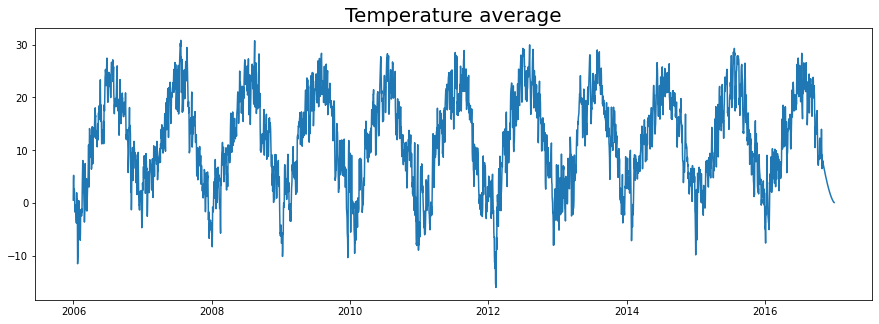

In [30]:
#plot dataset
dates = df['Formatted Date'].values
temp  = df['Temperature (C)'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [31]:
#bagi dataset menjadi 80% data training dan 20% data validation
df_train = df[:3217]
dates_train = df_train['Formatted Date']
temp_train = df_train['Temperature (C)']
df_validation = df[3217:]
dates_validation = df_validation['Formatted Date']
temp_validation = df_validation['Temperature (C)']
df_train.tail(), df_validation.head()

(                Formatted Date  Temperature (C)
 3212 2014-10-17 00:00:00+00:00        14.927315
 3213 2014-10-18 00:00:00+00:00        13.390972
 3214 2014-10-19 00:00:00+00:00        11.443981
 3215 2014-10-20 00:00:00+00:00        14.743750
 3216 2014-10-21 00:00:00+00:00        14.340972,
                 Formatted Date  Temperature (C)
 3217 2014-10-22 00:00:00+00:00         9.575000
 3218 2014-10-23 00:00:00+00:00         8.143287
 3219 2014-10-24 00:00:00+00:00         7.901852
 3220 2014-10-25 00:00:00+00:00         7.822917
 3221 2014-10-26 00:00:00+00:00         6.696296)

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [33]:
#buat model
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(temp_validation, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [34]:
#Gunakan Callback agar proses otomatis berhenti ketika mae model memenuhi kriteria (MAE < 10% skala data)
#skala data = 50, 10% dari skala data berarti 5
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae' and 'val_mae')<5):
      print("\nMAE MODEL KURANG DARI 10%, PELATIHAN MODEL DIHENTIKAN.")
      self.model.stop_training = True

callbacks = myCallback()

In [35]:
#latih model
history = model.fit(train_set,  validation_data=validation_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
32/32 [==============================] - 7s 90ms/step - loss: 12.3728 - mae: 12.8656 - val_loss: 11.6116 - val_mae: 12.1024
Epoch 2/100
32/32 [==============================] - 2s 44ms/step - loss: 12.1145 - mae: 12.6077 - val_loss: 11.3659 - val_mae: 11.8556
Epoch 3/100
32/32 [==============================] - 2s 45ms/step - loss: 11.8970 - mae: 12.3901 - val_loss: 11.1579 - val_mae: 11.6467
Epoch 4/100
32/32 [==============================] - 2s 44ms/step - loss: 11.6952 - mae: 12.1879 - val_loss: 10.9269 - val_mae: 11.4141
Epoch 5/100
32/32 [==============================] - 2s 45ms/step - loss: 11.4363 - mae: 11.9285 - val_loss: 10.6196 - val_mae: 11.1058
Epoch 6/100
32/32 [==============================] - 2s 45ms/step - loss: 11.1176 - mae: 11.6093 - val_loss: 10.2481 - val_mae: 10.7331
Epoch 7/100
32/32 [==============================] - 2s 46ms/step - loss: 10.7188 - mae: 11.2090 - val_loss: 9.7779 - val_mae: 10.2599
Epoch 8/100
32/32 [==============================

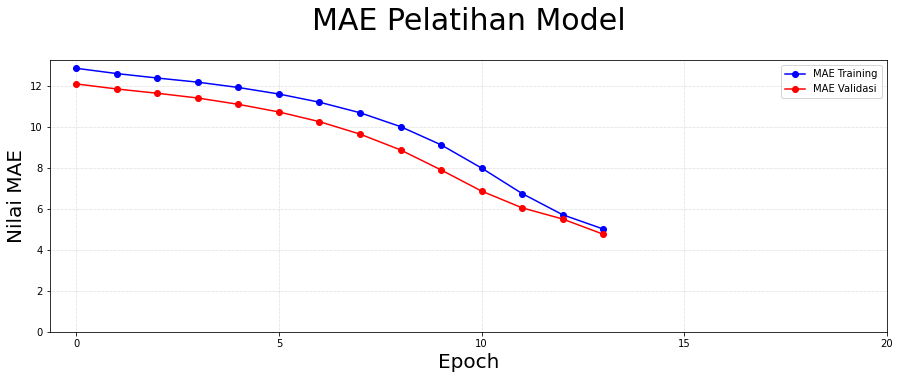

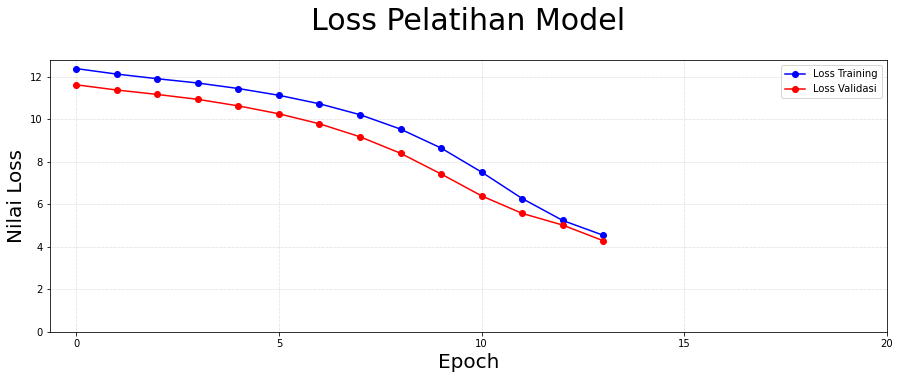

In [36]:
#visualisasi hasil pelatihan model

mae = history.history['mae'] #mae training
val_mae = history.history['val_mae'] #mae validation
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(mae)) #jumlah epoch

plt.figure(figsize=(15,5))
plt.plot(epochs, mae, marker='o', color='blue', label='MAE Training')
plt.plot(epochs, val_mae, marker='o', color='red', label='MAE Validasi')
plt.legend()
plt.title('MAE Pelatihan Model', pad=30, fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Nilai MAE', fontsize=20)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.xticks([0,5,10,15,20])
plt.ylim(ymin=0)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(epochs, loss, marker='o', color='blue', label='Loss Training')
plt.plot(epochs, val_loss, marker='o', color='red', label='Loss Validasi')
plt.legend()
plt.title('Loss Pelatihan Model', pad=30, fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Nilai Loss', fontsize=20)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.xticks([0,5,10,15,20])
plt.ylim(ymin=0)
plt.show()